<a href="https://colab.research.google.com/github/sugi-san/others/blob/main/rembg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

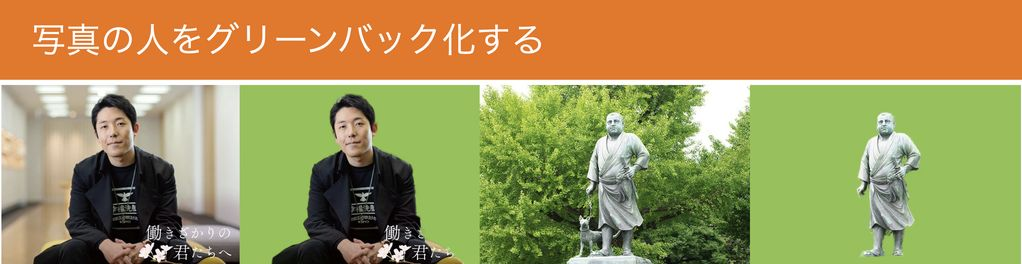

In [ ]:
#@title 1.セットアップ（３分くらいかかります）
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:

      # githubからコードを取得
      !git clone https://github.com/sugi-san/others.git
      pbar.update(5)

      # pipアップデート
      !pip install -U pip
      pbar.update(5)

      !pip install torch==1.7.1+cpu torchvision==0.8.2+cpu -f https://download.pytorch.org/whl/torch_stable.html
      pbar.update(60)

      # rembgインストール
      !pip install rembg
      # 修正パッチのコピー
      import shutil
      shutil.copy('./others/rembg/bg.py', '/usr/local/lib/python3.7/dist-packages/rembg/bg.py')
      pbar.update(30)

except subprocess.CalledProcessError:
  print(captured)
  raise

# ▲上段にある「ランタイム/ランタイムを再起動」をクリックする


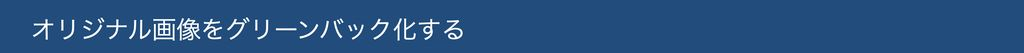

In [ ]:
#@title 2.画像のアップロード（jpg あるいは png）
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import shutil
from google.colab import files

# 表示関数定義
def display_pic(folder):
    fig = plt.figure(figsize=(20, 20))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        if file == '.ipynb_checkpoints':
          continue  
        img = Image.open(folder+'/'+file) 
        images = np.asarray(img)
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(file, fontsize=20)               
    plt.show()
    plt.close()

# picフォルダーリセット
if os.path.isdir('pic'):
    shutil.rmtree('pic')
os.makedirs('pic', exist_ok=True)

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートからpicフォルダーへ移動
for i in range(len(uploaded)):
    shutil.move(uploaded[i], './pic/'+uploaded[i])

# picフォルダー内表示
display_pic('pic')

In [ ]:
#@title 3.グリーンバック化
from rembg.bg import remove
import numpy as np
import io
from PIL import Image
import os
import shutil

# 指定画像をsample.pngにコピー（jpgならpngに変換）
input = '' #@param {type:"string"}
kakuchoshi = os.path.splitext(input)
if kakuchoshi[1] == '.jpg' or kakuchoshi[1] == '.jpeg':
  im = Image.open('./pic/'+input)
  im.save('sample.png')
if kakuchoshi[1] == '.png':
  shutil.copy('./pic/'+input, 'sample.png')

# 切り抜き画像作成（背景透明化）
input_path = 'sample.png'
output_path = 'cutout.png'

f = np.fromfile(input_path)
result = remove(f,
                alpha_matting=True,
                alpha_matting_foreground_threshold=240,
                alpha_matting_background_threshold=10,
                alpha_matting_erode_structure_size=6)
img = Image.open(io.BytesIO(result)).convert("RGBA")
img.save(output_path)

# 切り抜き画像とグリーンバック画像の読み込み
img = Image.open('cutout.png').convert('RGBA')
bg = Image.open('./others/rembg/greenback.png').convert('RGBA')

# グリーンバックを切り抜き画像サイズに合わせる
w, h = img.size
bg = bg.resize((w, h))

# 合成
img_clear = Image.new("RGBA", bg.size, (255, 255, 255, 0))
img_clear.paste(img, (0,0))
bg = Image.alpha_composite(bg, img_clear)

# グリーンバック画像保存（png & jpg）
bg.save('merge.png')
im = Image.open('merge.png')
im = im.convert('RGB')
im.save('merge.jpg')

# 画像表示
from IPython.display import Image, display_png
display_png(Image('merge.png'))

In [ ]:
#@title 4.グリーンバック画像のダウンロード
from google.colab import files
files.download('merge.jpg')

###【備考】
・ブラウザは、必ずGoogle Chromeを使用して下さい。

・動作がおかしくなった場合は、右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックして、再度１番から順番に操作を行います。

・このノートを実行して閉じてから、すぐ再度実行する場合は、前の記憶が不完全に残っていて上手く動かないことがあります。その場合は、右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックして、再度１番から操作を行います。

・長時間使用するとgoogleから使用制限を受ける場合がありますが、12h〜24h程度経つと使用制限が解除されます。